In [12]:
import yfinance as yf
import pandas as pd


In [13]:
ticker = "SPY"

data = yf.download(
    ticker,
    period="10y",      # last 1 year
    interval="1d",    # daily data
    auto_adjust=True  # adjusts for splits/dividends
)



[*********************100%***********************]  1 of 1 completed


In [14]:
close_prices = data["Close"]
print(close_prices.head())


Ticker             SPY
Date                  
2016-01-27  159.447433
2016-01-28  160.278046
2016-01-29  164.185165
2016-02-01  164.125809
2016-02-02  161.167938


In [15]:
import numpy as np

log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
log_returns.name = "Log Returns"


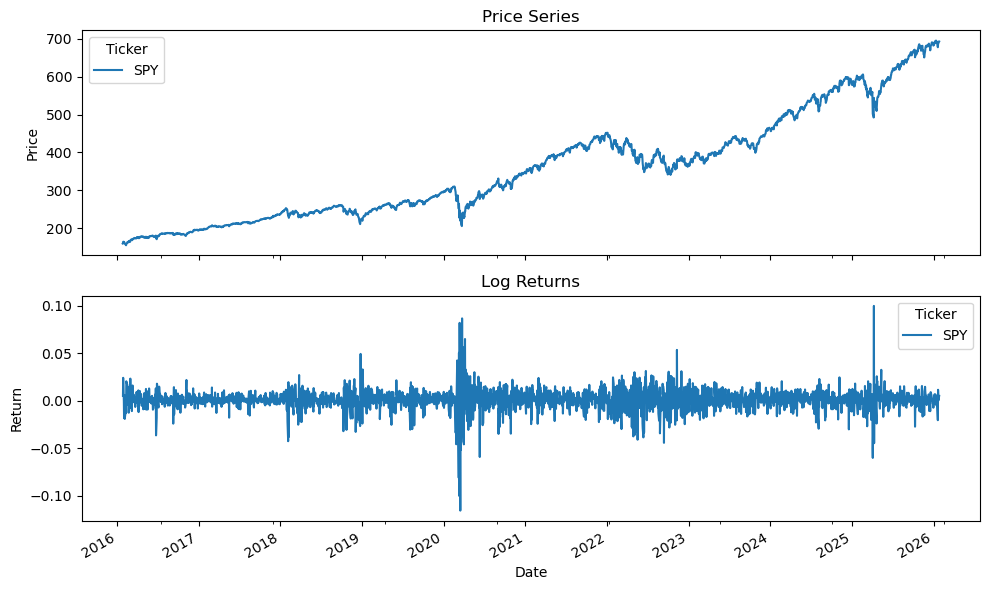

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

close_prices.plot(ax=ax[0], title="Price Series")
ax[0].set_ylabel("Price")

log_returns.plot(ax=ax[1], title="Log Returns")
ax[1].set_ylabel("Return")

plt.tight_layout()
plt.show()


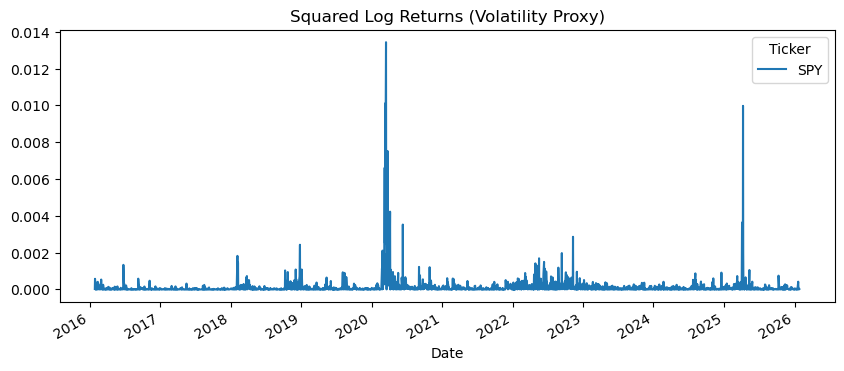

In [17]:
(log_returns**2).plot(figsize=(10,4), title="Squared Log Returns (Volatility Proxy)")
plt.show()


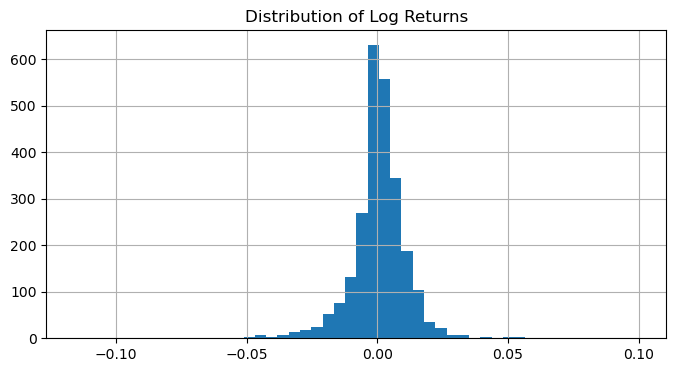

In [18]:
log_returns.hist(bins=50, figsize=(8,4))
plt.title("Distribution of Log Returns")
plt.show()


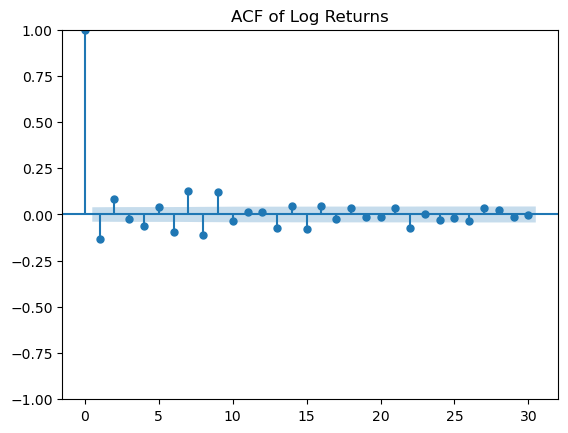

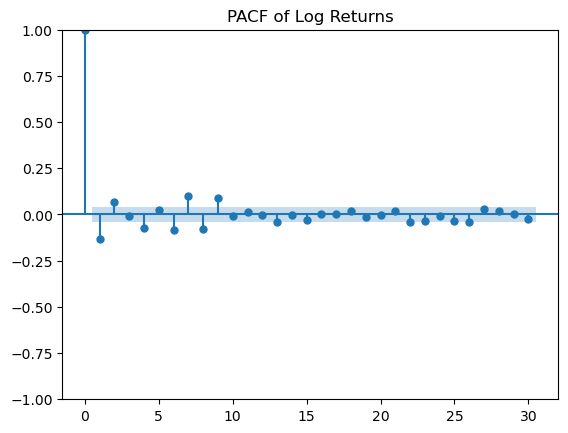

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(log_returns, lags=30)
plt.title("ACF of Log Returns")
plt.show()

plot_pacf(log_returns, lags=30)
plt.title("PACF of Log Returns")
plt.show()


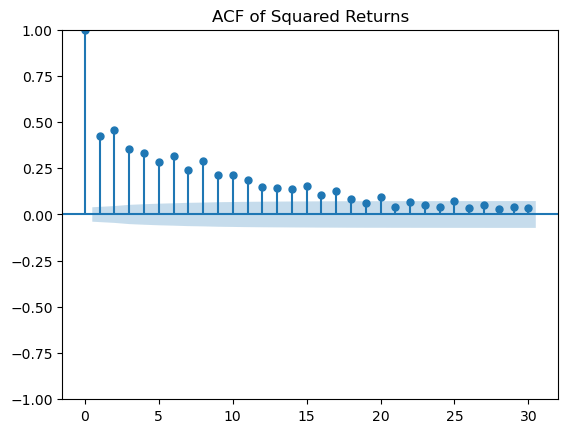

In [22]:
plot_acf(log_returns**2, lags=30)
plt.title("ACF of Squared Returns")
plt.show()


# fit mean model

In [38]:
import statsmodels.api as sm
# AR(1)
model_ar1 = sm.tsa.ARIMA(log_returns, order=(1,0,0)).fit()

# MA(1)
model_ma1 = sm.tsa.ARIMA(log_returns, order=(0,0,1)).fit()

# ARMA(1,1)
model_arma11 = sm.tsa.ARIMA(log_returns, order=(1,0,1)).fit()

# ARMA(2,2)
model_arma22 = sm.tsa.ARIMA(log_returns, order=(2,0,2)).fit()

# AR(9)
model_ar9 = sm.tsa.ARIMA(log_returns, order=(9,0,0)).fit()

# MA(9)
model_ma9 = sm.tsa.ARIMA(log_returns, order=(0,0,9)).fit()

# ARMA(9,9)
model_arma99 = sm.tsa.ARIMA(log_returns, order=(9,0,9)).fit()

/Users/alexwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

In [39]:
bic_table = {
    "AR(1)": model_ar1.bic,
    "MA(1)": model_ma1.bic,
    "ARMA(1,1)": model_arma11.bic,
    "ARMA(2,2)": model_arma22.bic,
    "AR(9)": model_ar9.bic,
    "MA(9)": model_ma9.bic,
    "ARMA(9,9)": model_arma99.bic,
}

for k, v in bic_table.items():
    print(f"{k}: BIC = {v:.2f}")


AR(1): BIC = -15411.88
MA(1): BIC = -15406.28
ARMA(1,1): BIC = -15408.51
ARMA(2,2): BIC = -15398.22
AR(9): BIC = -15454.06
MA(9): BIC = -15435.74
ARMA(9,9): BIC = -15393.52


In [40]:
best_model_name = min(bic_table, key=bic_table.get)
print("Best model based on BIC:", best_model_name)


Best model based on BIC: AR(9)


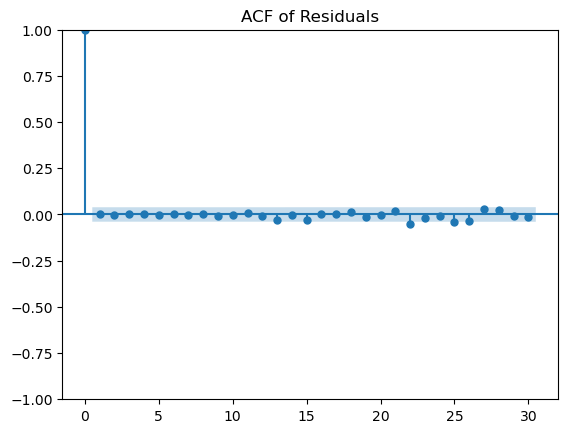

In [42]:
# we chose AR(9)
residuals = model_ar9.resid


from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()


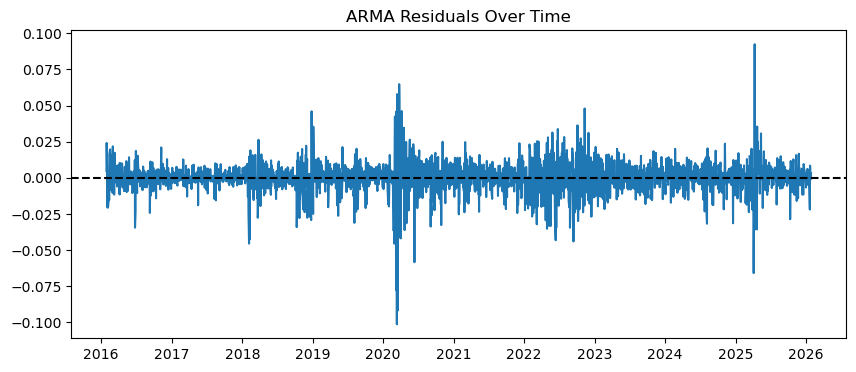

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("ARMA Residuals Over Time")
plt.axhline(0, color="black", linestyle="--")
plt.show()


In [44]:
# we see that there are some volatility clustering

# GARCH model

In [45]:
!pip install arch


  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/b5/42/7f1b880857839ea0841304586715c7d2a477552d04bcde32d1d55d8ccaa0/arch-8.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.8/929.8 kB 6.1 MB/s eta 0:00:00a 0:00:01


In [65]:
from arch import arch_model
residuals = 100* residuals
garch_11 = arch_model(
    residuals,
    mean='Zero',       # mean already modeled by AR(9)
    vol='GARCH',
    p=1,
    q=1,
    dist='normal'
).fit(disp='off')
garch_21 = arch_model(
    residuals,
    mean='Zero',
    vol='GARCH',
    p=2,
    q=1,
    dist='normal'
).fit(disp='off')
garch_12 = arch_model(
    residuals,
    mean='Zero',
    vol='GARCH',
    p=1,
    q=2,
    dist='normal'
).fit(disp='off')
bic_garch = {
    "GARCH(1,1)": garch_11.bic,
    "GARCH(2,1)": garch_21.bic,
    "GARCH(1,2)": garch_12.bic
}

for k, v in bic_garch.items():
    print(f"{k}: BIC = {v:.2f}")
best_garch = min(bic_garch, key=bic_garch.get)
print("Best GARCH model based on BIC:", best_garch)


GARCH(1,1): BIC = 6515.17
GARCH(2,1): BIC = 6522.93
GARCH(1,2): BIC = 6523.00
Best GARCH model based on BIC: GARCH(1,1)


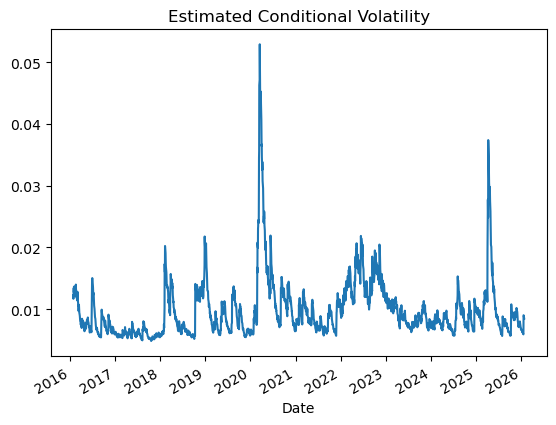

In [66]:
conditional_vol = garch_result.conditional_volatility
conditional_vol.plot(title="Estimated Conditional Volatility")
plt.show()


In [67]:
std_resid = garch_result.resid / garch_result.conditional_volatility


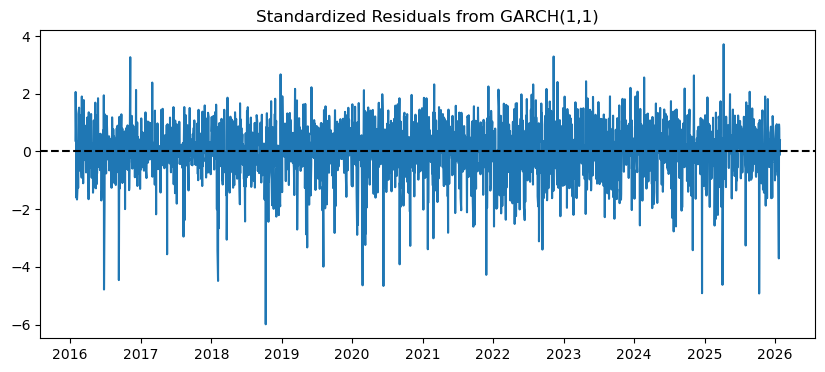

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(std_resid)
plt.title("Standardized Residuals from GARCH(1,1)")
plt.axhline(0, color='black', linestyle='--')
plt.show()


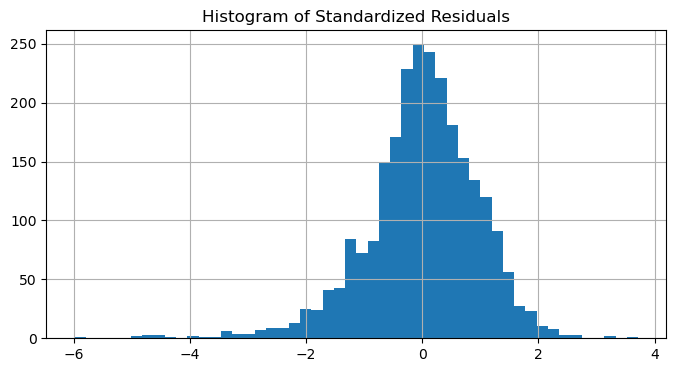

In [69]:
std_resid.hist(bins=50, figsize=(8,4))
plt.title("Histogram of Standardized Residuals")
plt.show()


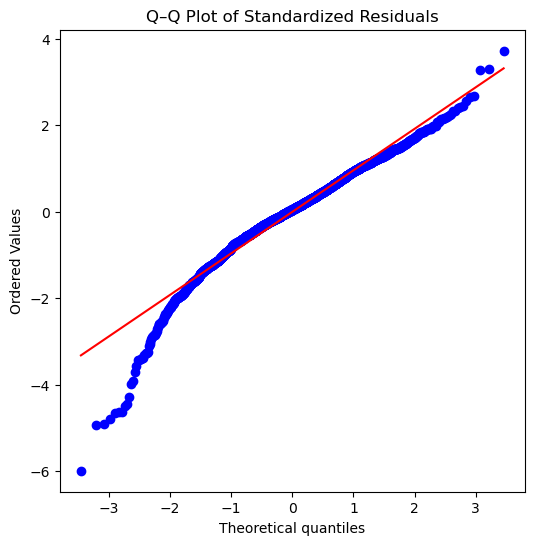

In [70]:
import scipy.stats as stats

plt.figure(figsize=(6,6))
stats.probplot(std_resid, dist="norm", plot=plt)
plt.title("Q–Q Plot of Standardized Residuals")
plt.show()


In [71]:
from arch import arch_model

garch_skt = arch_model(
    residuals,
    mean='Zero',
    vol='GARCH',
    p=1,
    q=1,
    dist='skewt'   # skewed Student-t
).fit(disp='off')

print(garch_skt.summary())


                             Zero Mean - GARCH Model Results                             
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -3136.65
Distribution:      Standardized Skew Student's t   AIC:                           6283.30
Method:                       Maximum Likelihood   BIC:                           6312.45
                                                   No. Observations:                 2513
Date:                           Tue, Jan 27 2026   Df Residuals:                     2513
Time:                                   00:33:02   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

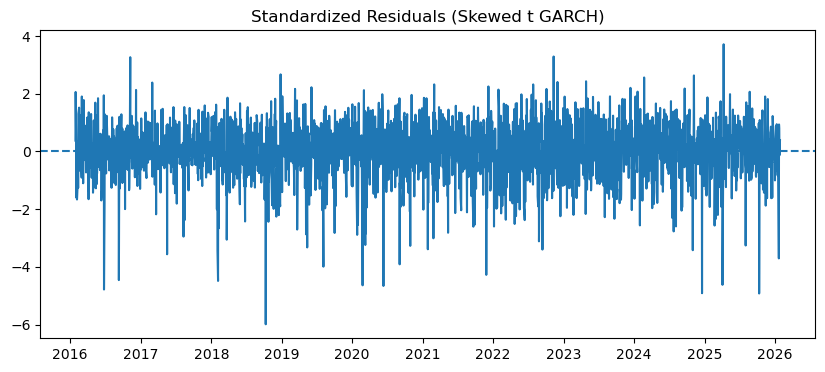

In [61]:
std_resid_skt = garch_skt.resid / garch_skt.conditional_volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(std_resid_skt)
plt.title("Standardized Residuals (Skewed t GARCH)")
plt.axhline(0, linestyle='--')
plt.show()


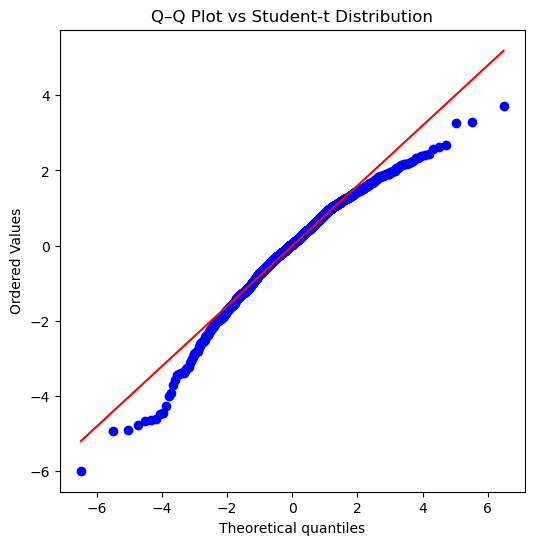

In [63]:
import scipy.stats as stats

df = garch_skt.params['eta']   # degrees of freedom

plt.figure(figsize=(6,6))
stats.probplot(std_resid_skt, dist=stats.t, sparams=(df,), plot=plt)
plt.title("Q–Q Plot vs Student-t Distribution")
plt.show()


In [72]:
import numpy as np

# In-sample conditional variance h_t
h_t = (garch_skt.conditional_volatility ** 2)

# Realized variance proxy (squared innovations)
e2_t = (residuals ** 2).reindex(h_t.index)

# QLIKE = mean( log(h_t) + e2_t / h_t )
qlike_in_sample = np.mean(np.log(h_t) + (e2_t / h_t))
print("QLIKE (in-sample, skew-t):", qlike_in_sample)


QLIKE (in-sample, skew-t): 0.752830991806415


In [74]:
import numpy as np
import pandas as pd
from arch import arch_model

y = residuals.dropna()

# Choose test length (for example, last 20% as test)
test_size = int(0.2 * len(y))
train_end = len(y) - test_size

h_forecast = []
e2_realized = []
forecast_index = []

for t in range(train_end, len(y)):
    train_y = y.iloc[:t]  # expanding window; use y.iloc[t-window:t] for rolling window

    m = arch_model(train_y, mean="Zero", vol="GARCH", p=1, q=1, dist="skewt")
    res = m.fit(disp="off")

    # 1-step-ahead forecast variance
    f = res.forecast(horizon=1, reindex=False)
    h1 = float(f.variance.iloc[-1, 0])

    # realized variance proxy at time t
    e2 = float(y.iloc[t] ** 2)

    h_forecast.append(h1)
    e2_realized.append(e2)
    forecast_index.append(y.index[t])

h_forecast = pd.Series(h_forecast, index=forecast_index, name="h_forecast")
e2_realized = pd.Series(e2_realized, index=forecast_index, name="e2_realized")

qlike_oos = np.mean(np.log(h_forecast) + (e2_realized / h_forecast))
print("QLIKE (out-of-sample rolling 1-step, skew-t):", qlike_oos)


QLIKE (out-of-sample rolling 1-step, skew-t): 0.8007462234277402
